# Characterization of planet atmospheres with SPIRou

The goal of this tutorial is to provide the user with simple tools to robustly analyse sequences of spectra collected with SPIRou during a planetary transit. It is based on a publicly-available standard sequence of 96 observations of the variable M2 star <b>Gl 15A</b> (also named <b>V* GX And</b>, or <b>HD 1326</b>, see http://simbad.u-strasbg.fr/simbad/sim-id?Ident=Gl%2015%20A). Note that the original sequence of spectra contains 192 spectra and we decided to reduce it by half to save computational time for this tutorial (the full sequence can be access on the Canadian Astronomy Data Center: https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/; date: 2020-10-08, PI: Donati, DRS version: 0.6.132). 


### Goal of the turorial
 As no transiting planet is known to orbit Gl 15A, we will inject a realistic synthetic planet atmosphere signature into the observed sequence of spectra. Then, assuming that the planet ephemerides are known, we will aim at recovering the injected planet atmosphere spectrum using a correlation analysis. This tutorial is thus divided into 3 main sections:



0. **Preparing the data**

    0.1. Read a time series of telluric-corrected SPIRou files in a given directory (here: Data/). This code assume that the spectra are corrected for telluric contamination using the method of [Artigau et al. 2014](https://ui.adsabs.harvard.edu/abs/2014SPIE.9149E..05A/abstract) (**f.fits** files). For each spectrum, we access the wavelength solution, spectrum, blaze solution and estimated telluric spectrum for each of the **49** SPIRou orders. For more information about SPIRou, please have a look to [Donati et al. 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.498.5684D/abstract) and to the fantastic [SPIRou webpage](http://spirou.irap.omp.eu/) (see also incoming article about the SPIRou data reduction software or DRS, from Cook et al., in prep.).
    
    0.2. Visualize the data sets as well as relevant time series for the analysis: S/N per order, airmass, barycentric Earth radial velocity (BERV), transit ephemerides.
    
    0.3. Inject synthetic planet signature. We computed self-consistent atmospheric models of a hot Jupiter (Teq=1500K, metallicity= 1xsolar) and a warm Neptune (Teq=600K, metallicity=30xsolar) using Exo-REM ([Blain et al. 2021](https://www.aanda.org/articles/aa/full_html/2021/02/aa39072-20/aa39072-20.html), available online at: https://gitlab.obspm.fr/dblain/exorem). The calculations include non-equilibrium chemistry. From the outputs of Exo-REM, we produced high-resolution transit spectra (R=750000) with a line-by-line model. We produced also molecular templates (H2O, CH4, CO and NH3) corresponding to their contribution in the transit spectra. 
    Then, we simply build a synthetic sequence of spectra by multiplying the planet atmosphere template (i.e. wavelength-dependent transit depth) by the transit window (i.e. portion of the stellar covered by the planet) at every epoch of observation. We then multiply the input (blaze subtracted) data by the synthetic sequence of spectra, shifted into the Geocentric frame beforehand.
    
    

1. **Data reduction process: removing telluric and stellar spectra from the observed sequence and normalize the spectra**

    1.1. Exclude regions of strong telluric contaminations to reduce potential systematics in the analysis. This follows the method of [Boucher et al. 2021](https://ui.adsabs.harvard.edu/abs/2021arXiv210808390B/abstract)
    
    1.2. Interpolate and shift the spectra into the stellar rest frame (correct for BERV and stellar systemic RV and planet-induced signature)
    
    1.3. Remove the median spectrum from each observed spectrum
    
    1.4. Jointly normalize the spectra and remove strong outliers
    
    1.5. Detrend with airmass to filter most of the residuals of airmass-dependent features
    
    1.6. Reject bad pixels
    
    1.7. Remove residuals of correlation noise using a Princical component analysis (PCA) based approach



2. **Retrieve the planet signature**

    We propose the retrieve the injected planet atmosphere spectrum using a matching template analysis (often falsely denoted as cross-correlation analysis). The reduced sequence of spectra is iteratively compared to synthetic sequences of spectra created by shifting a given planet atmosphere template to different planet RV solutions (based on a grid of planet RV semi-amplitude Kp and RV at mid-transit Vsys). For each value of Kp and Vsys, we compute the associated planet RV, and create a synthetic sequence of spectra by (i) shifting the planet model according to the RV solution and (ii) weighting it by the transit window at each observing time. We then compute the correlation between the synthetic map and the observed sequence of spectra. This yields a correlation map in the (Kp,Vsys) space that can be converted to a 'significance' map. If the template matches the observations for the expected values of Kp and Vsys, this will reinforce the idea that the planet signal is indeed present in the data. By repeating the process for different planet atmosphere templates, we can do model comparison by comparing the obtained significance maps. A more robust way to do so is to perform a Markov Chain Monte Carlo process using the correlation-to-likelihood framework of [Brogi & Line 2019](https://ui.adsabs.harvard.edu/abs/2019AJ....157..114B/abstract). A more complete introduction about the analysis of exoplanet atmospheres at high resolution can be found in the review of [Birkby 2018](https://ui.adsabs.harvard.edu/abs/2018arXiv180604617B/abstract). 
    
    
    
### Structure of the code

The code is organised as follows

- All the data used in the code are stored in the directory **Data/T_files**. Note that the names of the files are assumed to be ordered in the chronological order. This condition is systematially fulfilled for DRS-provided SPIRou files but it might be worth checking that the observational time is an inceasing function.

- The models used in the tutorial are stored in the directory **Models/**. In this version, the format of each planet template is a 2-column file containing (1) the wave number in cm^(-1) and (2) the transit depth. This can be easily modified in Section 1.3 of the notebook.

- The data reduction process is applied independently to each of the 49 SPIRou orders. We chose to work with a list of objects named **Order**  containing all attributes and relevant method for a given SPIRou order. All information about the Order object can be found in the **src.py** python file. In addition, more generic functions (not linked to the Order object) can be found in the lower part of the file.

- Once the stellar and telluric spectra have been removed from each order in Section 1, the correlation process (matching template) is applied to a user-provided input list of orders. The process takes typically about 1 hour to combine all orders (~200 000 data points). To gain time in this tutorial, we propose to combine no more than a few orders (3-7). Note that we however recommend to combine as many orders, if relevant (e.g., contains enough planet signal and not too polluted by tellurics). All functions associated to the matching template algorithm can be found in the **correlation.py** python file.

- All functions related to the plots shown in this notebook can be accessed in the **plots.py** python file.


### Dependencies

No major dependencies is required to make the code run, but make sure that you use:
- python3 (>3.5 typically)
- scipy + astropy modules
- pandas python module
- If you want to compute a transit flux (optional), you will need to install the **batman** python module: https://lweb.cfa.harvard.edu/~lkreidberg/batman/



### Questions ?

If you have any question about the code please contact:
- Baptiste Klein, baptiste.klein@physics.ox.ac.uk
- Florian Debras, florian.debras@irap.omp.eu
- Benjamin Charnay, benjamin.charnay@obspm.fr
    


<font color='pink'>######### Have fun during this tutorial! ##################</font>    


In [1]:
### Dependencies of the notebook
import numpy as np
import sys
import os
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import pandas as pd
import copy
from src import *
from plots import *
from correlation import *
font = {'size'   : 16,
        'weight': 'light'}
axes = {'labelsize': 16,
        'labelweight': 'light'}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)

## 0. Read data

This section aims at reading the input SPIRou observations and injecting a synthetic planet atmosphere spectrum therein. 
<font color='red'>A few notes:</font>
- The cell below contains the main parameters to read the data and compute a realistic planet template. 
- In this example, the planet properties are based on the hot Jupiter **HD 189733 b**. In order to inject a realistic planet signature in the data, we need to compute a so-called transit window given the fraction of the planet occulting the star. Usually, this is done by computing a transit curve (e.g., using the python [batman module](https://lweb.cfa.harvard.edu/~lkreidberg/batman/). Since the installation of the module can be quite tricky depending on the distribution of your laptop, we pre-computed a transit curve (see file **transit_flux.dat**). Note however that the function **compute_transit** (in **src.py**) can be uncommented and used for any input planet parameters. Since a transit curve is already computed, the following star/planets parameters are actually not used in the code: Rp, Rs, ap, ep, ip, wp, limb dark, uh. Note: a realistic estimate of the stellar limb-darkening coefficients can be found on [this website](https://vizier.u-strasbg.fr/viz-bin/VizieR-4).
- <font color='red'>Important note:</font> In this tutorial, SPIRou orders are designated by the absolute index. In other words, the reddest order is Order 31 whereas the bluest is Order 79. **Note that the mean wavelength corresponding to each order number can be found in the output of Section 1.1**.


In [2]:
# -----------------------------------------------------------------------
# GLOBAL PARAMETERS
dir_data   = "Data/T_files"   ### Directory containing all 
orders     =  np.arange(31,80)[::-1].tolist() ### List of all orders analysed

# -----------------------------------------------------------------------
# STELLAR / PLANET PARAMETERS
Ks        = 0.205                            #Planet semi-amplitude [km/s]
T0        = 2459130.8962180                  #Mid-transit time [BJD]
Porb      = 2.21857545                       #Planet orbital period [d]
V0        = 11.73                            #Stellar Systemic Vel [km/s]

### Used to compute transit window only
Rp        = 82914.446                        #Planet radius [km]   
Rs        = 528034.0                         #Stellar radius [km]
ap        = 8.839304998                      #Semi-major axis [stellar radius]
ep        = 0.0041                           #Orbital eccentricity
ip        = 85.710                           #Orbital inclination [deg]
wp        = -24.1                            #Argument of the periapsis [deg] 
limb_dark = "quadratic"                      #limb darkening model ("nonlinear", "quadratic", "linear")
uh        = [0.0788,0.2679]                  #Values of limb-darkening coefficients
#### Accessible here --> https://vizier.u-strasbg.fr/viz-bin/VizieR-4 

### Transit flux
dir_transit = "transit_flux.dat"             #Pre-computed transit flux values


#### 0.1. Read and pre-process data

In this section, we perform the following pre-processing steps:
- Read all data present in the directory **Data/T_files** (parameter **dir_data**), assuming that the files are ordered in the chronological order
- These files are DRS **t.fits** files, computed using the method described in [Artigau et al. 2014](https://ui.adsabs.harvard.edu/abs/2014SPIE.9149E..05A/abstract) (optimized for SPIRou --> see Cook et al., in prep. about the SPIRou DRS). In these files, regions of strong telluric absorptions are replaced by NaNs (to avoid insecure estimates of the stellar flux). Before working with the data, we flag all pixels for which a NaN value appear once of more. These pixels are removed from the observations.
- We compute the transit window from the transit flux for the simulation planet and spot the start-of-transit and end-of-transit dates
- We compute the RV correction between the Geocentric (or Tropospheric) frame (where the SPIRou spectra are taken) and the stellar rest frame. The RV correction Vc is given by: Vc = V0 + Vp - berv, where V0 is the systemic velocity of the star, Vp is the planet signature induced on the host star and berv is the barycentric Earth RV. Note that, in this example, we do not include Vp as the planet is not acutally present in the data. Note also that the RV signature of the binary companion is neglicted in this analysis due to its very small long-term effect (see [Pinamonti et al. 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...617A.104P/abstract) for more infrmation about the system).
- We finally compute the planet orbital phase given by: phase = (T_obs-T0)/Porb, where T_obs are the observing times, T0 is the mid-transit time, and Porb is the planet orbital period.

In [3]:
### READ DATA - SUBTRACT BLAZE - REMOVE NaNs

print("\nRead data")
list_ord = []
nord     = len(orders)
for kk in range(nord):
    list_ord.append(Order(orders[kk])) ### Initialize list of Order objects
list_ord,airmass,T_obs,berv,snr_mat = read_data_spirou(dir_data,list_ord,nord)
nobs = len(T_obs)
print("DONE\n")

### Remove all NaNs and form array like structures
print("\nRemove NaNs")
cmp = 0
for mm in range(nord):
    O   = list_ord[cmp]   
    err = O.remove_nan()
    if err > 0: ### If only NaNs
        print("Order",O.number,"empty - removed")
        del orders[cmp]
        del list_ord[cmp]
    else: cmp += 1
nord = len(list_ord)
print("DONE\n")


print("\nCompute transit curve")
flux        = np.loadtxt(dir_transit,skiprows=1)[:,1]
window      = (1-flux)/np.max(1-flux)
n_ini,n_end = get_transit_dates(flux)
### Manual computation of the transit curve -- requires batman module
# flux = compute_transit(Rp,Rs,ip,T0,ap,Porb,ep,wp,limb_dark,uh,T_obs)
print("DONE\n")


print("\nCompute velocity correction - Geocentric frame to stellar rest frame")
Vp     =   get_rvs(T_obs,Ks,Porb,T0)  #[km/s]
Vc     =   V0 - berv 
#Vc     =  V0 + Vp - berv  ### When working with real data 
phase  = (T_obs - T0)/Porb
phase -= int(phase[-1])   
print("DONE\n")




Read data
DONE


Remove NaNs
DONE


Compute transit curve
DONE


Compute velocity correction - Geocentric frame to stellar rest frame
DONE



#### 0.2. Plot data
In this section, we simply visualize the data. We plot the following quantities:
- **Various time series:** (1) the transit curve which shows the fraction of the planetary transit covered by the observations, (2) the airmass, (3) the RV correction to move from the Geocentric frame to the stellar rest frame and (4) the order with maximum S/N (here, very high S/N of 260-300)
- **Distribution of S/N in time-order space**
- **A visualisation of the sequence of spectra collected for a given order** in the time-wavelength space

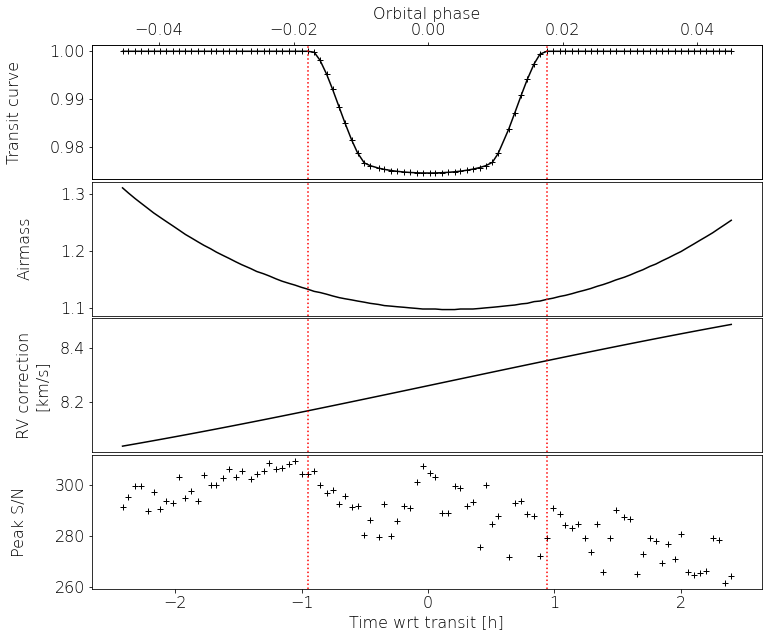

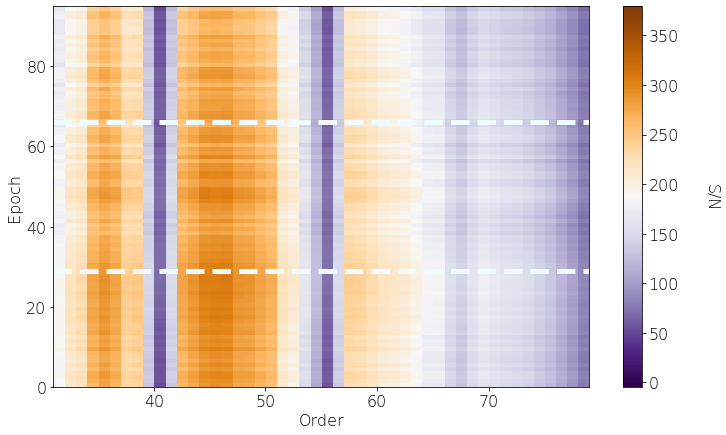

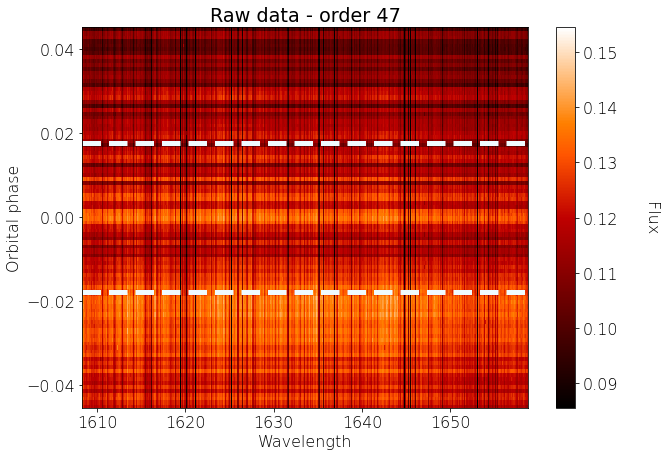

In [4]:
### Make plots

# Plot time series
plot_timeseries(T_obs,T0,Porb,phase,flux,n_ini,n_end,airmass,Vc,snr_mat)

# Plot S/N distribution
epoch = np.arange(nobs)
lab   = ["Order","Epoch","S/N"]
cmap  = "PuOr_r"
plot_2D(orders,epoch,snr_mat,lab,cmap,n_ini,n_end)

# Plot data and atmosphere spectrum for a given order
numb  = 47    # 31 --> reddest; 79 --> bluest
lab   = ["Wavelength","Orbital phase","Flux"]
cmap  = "gist_heat"
oo    = int(np.argmin(np.abs(np.array(orders,dtype=float)-numb)))
title = "Raw data - order " + str(list_ord[oo].number)
size  = (10,7)
plot_2D(list_ord[oo].W_raw,phase,list_ord[oo].I_raw,lab,cmap,n_ini,n_end,title,size)

title = "Telluric spectrum - order " + str(list_ord[oo].number)
# plot_2D(list_ord[oo].W_raw,phase,list_ord[oo].I_atm,lab,cmap,n_ini,n_end,title,size)



#### 1.3. Add synthetic planet signature 

We now add a synthetic planet signature to the data. 

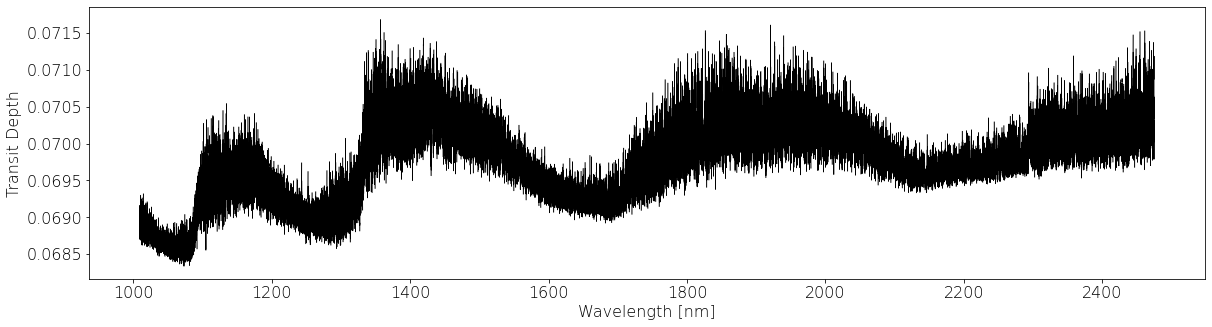

In [5]:
# Indicate below the name of the planet atmosphere template injected in the data
name_model        = "Model/Jupiter_1sol_Teq1500K_Tint150K"
#name_model        = "Model/Neptune_30sol_Teq600K_Tint50K"
aa                = np.loadtxt(name_model)

W_mod_inj         = aa[:,0]#   np.array(1./aa[:,0]*1e7)[::-1]
transit_depth_inj =  aa[:,1] #np.array(aa[:,1])[::-1]

plt.figure(figsize=(20,5))
plt.plot(W_mod_inj,transit_depth_inj,"-k",lw=.5)
plt.ylabel("Transit Depth")
plt.xlabel("Wavelength [nm]")
plt.show()

Select the semi-amplitude K_inj of the RV of the injected planet signature and the RV at mid-transit, V_inj. K_inj can be obtained from the star planet mass ratio (q = Ms/Mp) and the semi-amplitude of the RV signature induced by the planet of the host star, Ks, such that: **K_inj = q * Ks**. V_inj is expected to be close to 0 (non-zero values are interpreted as the presence of stellar winds towards or away from the observer). 

Order 79 incomplete -- discarded
Order 78 incomplete -- discarded
Order 77 incomplete -- discarded
Order 76 incomplete -- discarded


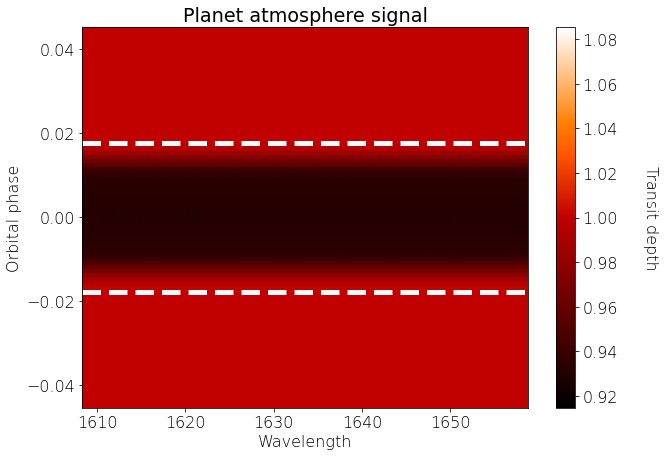

Order 31 incomplete -- discarded


In [6]:
###  Inject the planet signature into the data

K_inj       = 154.0   ### Semi-amplitude of the injected planet RV (Jupiter)
#K_inj       = 61.6   ### Semi-amplitude of the injected planet RV (Neptune)

V_inj       = 0.0     ### RV at mid-transit of the injected planet
numb        = 47      ### Select here the order for which you want to plot the synthetic planet signature

oo          = int(np.argmin(np.abs(np.array(orders,dtype=float)-numb)))
discard     = np.zeros(nord)
list_ord_pl = copy.deepcopy(list_ord) # Independent copy of the list of Order objects

for nn in range(nord):
    # Select and stored the synthetic data in a wavelength range encompassing each order
    O         = list_ord_pl[nn]
    Wmin,Wmax = 0.95*O.W_raw.min(),1.05*O.W_raw.max() # Take a wavelength range +/-5% larger than data
    indm      = np.where((W_mod_inj>Wmin)&(W_mod_inj<Wmax))[0]
    W_sel     = W_mod_inj[indm]
    I_sel     = transit_depth_inj[indm]
    
    # If some parts of the data are not covered by the model, discard the order
    if np.min(W_sel) > 0.999*np.min(O.W_raw) or np.max(W_sel) < 1.001*np.max(O.W_raw):
        print("Order",O.number,"incomplete -- discarded")
        discard[nn] = 1
    else:
        O.add_planet(W_sel,I_sel,window,phase,K_inj,V_inj,Vc)
        O.I_raw = O.I_raw_pl
    
    ### Display requested order
    if nn == oo:
        lab   = ["Wavelength","Orbital phase","Transit depth"]
        cmap  = "gist_heat"
        size  = (10,7)
        title = "Planet atmosphere signal"

        plot_2D(O.W_raw,phase,O.I_syn,lab,cmap,n_ini,n_end,title,size)

        ### Uncomment the line below to visualize the shift of the absorption lines during the transit
#         I_test = O.I_syn/(np.dot(np.mean(O.I_syn,axis=1).reshape(len(O.I_syn),1),np.ones((1,len(O.I_syn[0])))))
#         plot_2D(O.W_raw[1000:1500],phase,I_test[:,1000:1500],lab,cmap,n_ini,n_end,title,size)


# 1. Data reduction

#### 1.1. Exclude strong telluric contamination and discard orders not covered by template

We start by removing regions located within strong telluric absorption lines following the method introduced in [Boucher et al. 2021](https://ui.adsabs.harvard.edu/abs/2021arXiv210808390B/abstract). From the median DRS-provided Earth atmosphere spectrum, we flag all telluric lines with a relative absorption larger than dep_min (conservative value of 40% in [Boucher et al. 2021](https://ui.adsabs.harvard.edu/abs/2021arXiv210808390B/abstract) and set to 50%). We then remove points on both sides of each flagged absorption line until reaching a relative level of 1-thres_up with respect to the continuum. Orders with less than Npt_lim points remaining after the telluric exclusion are discarded from the analysis (typically ~6 orders with water absorption bands -- orders 55-57 and 40-42). 


**NOTE:** We provide here the list of **all SPIRou orders** and their associated mean wavelength. 

List of the orders selected for the analysis:
   Order W_mean [nm] Nb pts Nb pts removed       Status
0     79         974   2635            120  NOT COVERED
1     78         986   2617             10  NOT COVERED
2     77         998   2681              0  NOT COVERED
3     76        1012   2804              0  NOT COVERED
4     75        1026   2917              0           ok
5     74        1039   2976              0           ok
6     73        1053   3020              0           ok
7     72        1067   2853              0           ok
8     71        1082   2880              0           ok
9     70        1098   2934              0           ok
10    69        1113   2657            567           ok
11    68        1131   2552            987           ok
12    67        1147   2792            639           ok
13    66        1165   2991            150           ok
14    65        1183   3414            117           ok
15    64        1202   3360             57           ok
16

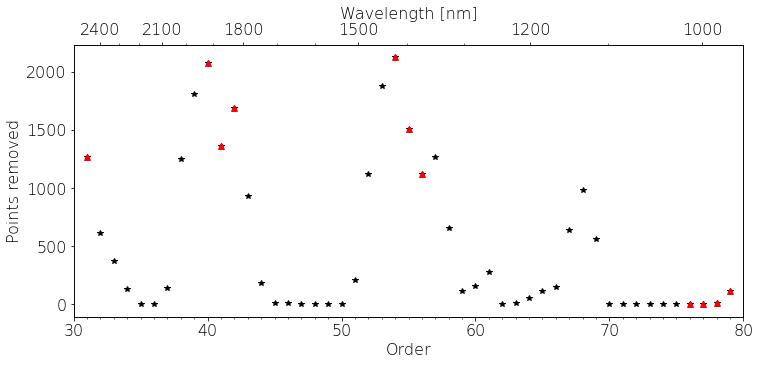

In [8]:
dep_min  = 0.5
thres_up = 0.05
### Remove regions of strong telluric absorption using Boucher et al. 2021 method
for nn in range(nord):
    list_ord_pl[nn].remove_tellurics(dep_min,thres_up)
    
### Remove all orders with less then Npt_lim pts remaining
### and display infos
Npt_lim = 500
npt_rem = np.arange(nord)
npt_ini = np.arange(nord)
ind_rem = []
ord_sta = ["ok" for i in range(nord)]
wmean   = np.arange(nord)

for nn in range(nord):
    O           = list_ord_pl[nn]
    
    npt_ini[nn] = len(O.W_raw)   
    npt_rem[nn] = len(O.W_raw) - len(O.W_cl)
    wmean[nn]   = O.W_mean    
    if discard[nn]>0:
        ind_rem.append(nn)
        ord_sta[nn] = "NOT COVERED"
    elif len(O.W_cl) <= Npt_lim:
        ind_rem.append(nn)
        ord_sta[nn] = "DISCARDED"        
list_ord_pl_fin =  np.delete(list_ord_pl,ind_rem)
nord_fin        = len(list_ord_pl_fin)
orders_fin      = np.delete(orders,ind_rem)
        
### Display results
infos = np.array([orders,wmean,npt_ini,npt_rem,ord_sta]).T
col   = ["Order","W_mean [nm]","Nb pts","Nb pts removed","Status"]
dtf   = pd.DataFrame(infos, columns=col)
print("List of the orders selected for the analysis:")
print(dtf)

### Display results
plot_orders(npt_rem,wmean,orders,ind_rem,laby="Points removed")

#### 1.2. Align spectra in the stellar rest frame

The data reduction procedure works with stellar spectra in the stellar rest frame. As the data are corrected for most of the telluric contamination (**t.fits** files), the spectra are dominated by the stellar contribution. As a consequence, working in the stellar rest frame allows us to remove the stellar contribution in a more efficient way than in the Geocentric frame (as the position of each stellar spectrum depends on the BERV). Note also that, when working with SPIRou e2ds files (or e.fits extensions), we may consider to do the data reduction process in the Geocentric frame. In this case, this will allow us to (i) remove more efficiently the telluric lines (aligned in the Geocentric frame) and (ii) avoid interpolating the observed spectra (no interpolation error added to the data).


We move the observed sequence of spectra from the Geocentric frame to the stellar rest frame, we process as follows:
- We interpolate each spectrum using scipy interp1d function (choose the type of interpolation by changing the parameter called "type"). 
- We shift the spectrum according to the velocimetric solution Vc computed in Section 0.1. Each value of the shifted spectrum is taken by intergrating the interpolation over one SPIRou pixel. 
- To avoid any extrapolation error, we remove the first and last **n_bor** points of each spectrum (note that, due to the blaze grating's structure, these points lie in regions of much higher noise level anyway).

In [9]:
frame    = "stellar"  ### "stellar" / "barycentric" vs "earth" / "geocentric"
n_bor    = 30
kind     = "linear"    ### "cubic" or "linear" --> see scipy interp1d page
print("\nInterpolate and align all spectra")
if frame == "stellar" or "barycentric":
    for nn in range(nord_fin):
        list_ord_pl_fin[nn].align(Vc,kind,n_bor)
print("DONE\n")


Interpolate and align all spectra
DONE



#### 1.3. Remove reference spectrum

The first step of the data reduction process consists in computing a high-S/N planet-free spectrum and remove it from each observed spectrum. In the stellar rest frame, the position of the stellar lines is constant (to the first order) during the observed sequence. In contrast, the position of the planet atmosphere lines is shifted by several km/s (several pixels) during the transit. As a consequence, the median observed spectrum should enclose most of the star contribution along with a negligible planet atmosphere contribution. To ensure that no planet atmosphere spectrum is enclosed in the median spectrum (especially when the RV semi amplitude of the planet is relatively low, e.g., for close-in planets less massive than Neptune), one option is to compute the median spectrum using only the out-of-transit spectra, but one has to ensure to have enough spectra in the baseline, in order to maximise the S/N of the reference spectrum.

In practice, we give the user the ability to select if the median spectrum is computed on all observations (**mode**="full") or on the out-of-transit spectra only (**mode**="out"). Once the median spectrum I_med is computed, we adjust I_med to each observed spectrum using a simple Least-squared estimator and divide the observed spectrum by the best-fitting prediction. We propose below to visualise the best-fitting solution for a given order (parameter **numb**).

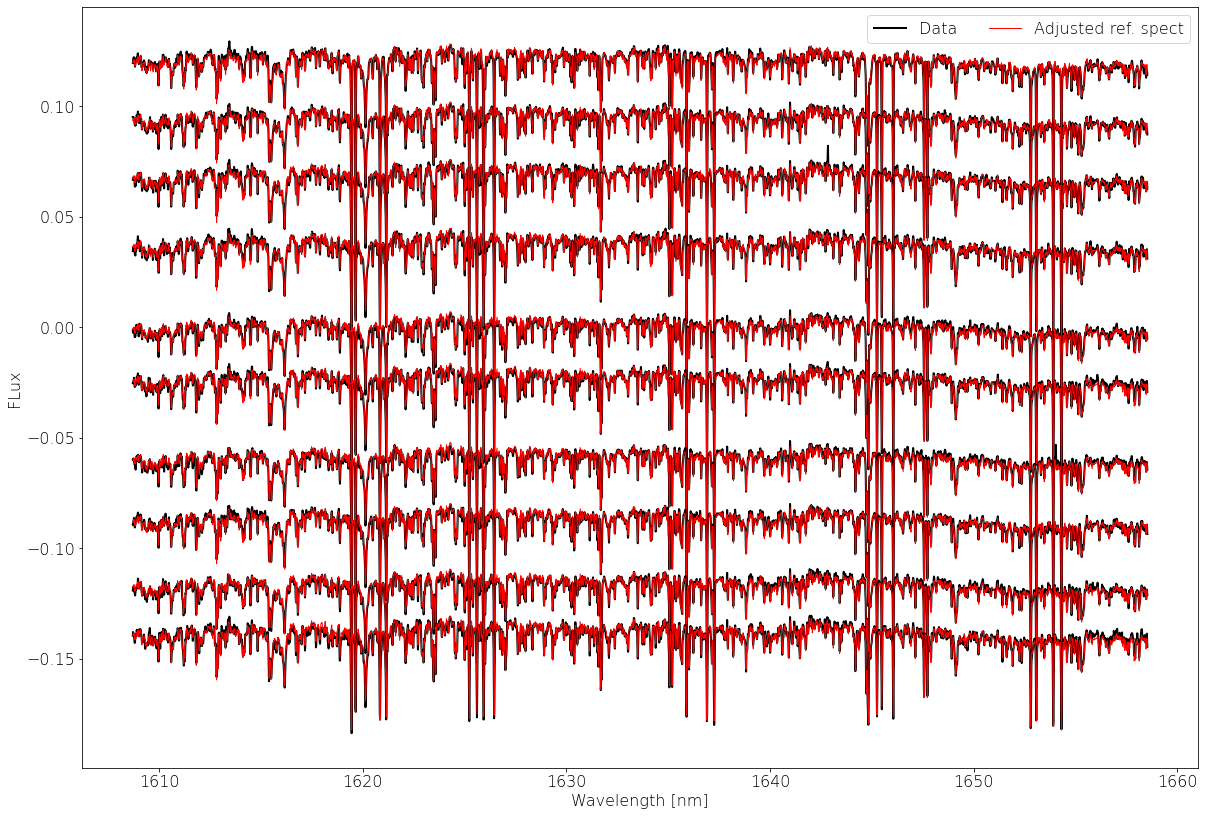

In [10]:
mode        = "out"  ### Compute median spec on "full" or "out"-of transit spectra
numb        = 47      ### Order for which we plot the prediction
oo          = int(np.argmin(np.abs(np.array(orders_fin,dtype=float)-numb)))

for kk in range(nord_fin):
    if kk == oo:
        list_ord_pl_fin[kk].subtract_stellar(mode,n_ini,n_end,True)        
    else:
        list_ord_pl_fin[kk].subtract_stellar(mode,n_ini,n_end,False)
        

#         lab   = ["Wavelength","Orbital phase","Flux"]
#         cmap  = "gist_heat"
#         title = "Raw data - order " + str(list_ord_fin[kk].number)
#         size  = (10,7)
#         plot_2D(list_ord[oo].W_al,phase,list_ord[oo].I_sub,lab,cmap,n_ini,n_end,title,size)

#### 1.4. Normalize the residual spectra

The resulting time series of spectra still exhibit low-frequencies structures due to correlated noise during the sequence (e.g., modal noise). Correcting for these trend as well as homogeneising the level of flux in each spectrum is a mandatory step in the correlation analysis. 

For each spectrum of each order, we perform the following iterative process:
- We apply a median filter (moving-median)
- Divide the spectrum by the moving median
- Conduct a sigma clipping to identify outliers
- For each flagged outlier, we remove a few adjacent points to correct for any potential pixel contamination
- We repeat the process until no outlier is identified

**WARNING:** This process typically takes a few min to run on all orders

**NOTE:** *There is no robust rule to tune the median filter here. Tests with synthetic data have shown that the results were marginally-impacted by variations of ~100 in N_med, as long as N_med is not too low or too large. One method to tune N_med for a given spectrum, would be to monitor the evolution of the dispersion of this spectrum normalized by the median filter for a range of N_med values. As N_med decreases (starting for abritrarily large values), the dispersion of the normalized spectrum will first decrease (correction of the low-frequency trends), reach a plateau, and decrease again (fit for white noise).*


Normalize residual spectra and remove outliers
Order n. 1 / 38
Order n. 11 / 38
Order n. 21 / 38


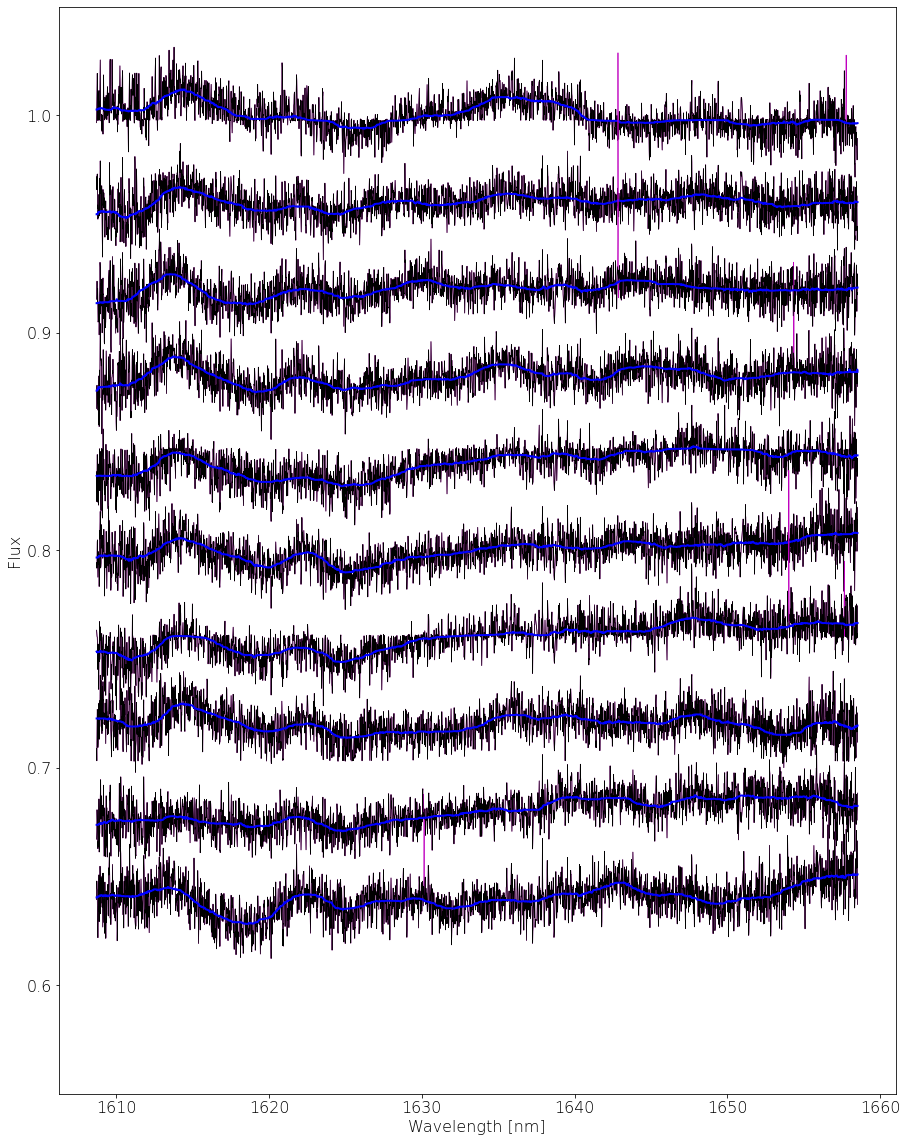

Order n. 31 / 38
DONE

Duration: 1.7229286154111227 min


In [11]:
N_med   = 200   # Number of points for the median filter
sig_out = 5     # Threshold for the sigma clipping [in sigma]
N_adj   = 2     # Number of adjacent points removed for each outlier identified 
numb    = 47    # Index of the order displayed
N_bor   = 30    # Number of points removed at each side of eahc order
oo      = int(np.argmin(np.abs(np.array(orders_fin,dtype=float)-numb)))
time0   = time.time()

print("\nNormalize residual spectra and remove outliers")
for kk in range(nord_fin):
    if kk != oo: plot = False
    else: plot = True
    if kk%10==0.0: print("Order n.",kk+1,"/",nord_fin)
    list_ord_pl_fin[kk].normalize(N_med,sig_out,N_adj,N_bor,plot)
print("DONE\n")
time1 = time.time()
print("Duration:",(time1-time0)/60.,"min")



#### 1.5. Detrending with airmass

Time-dependent residuals of absorption lines are still observed on the normalized spectra (residuals of strong lines whose absorption vary with airmass). A physically-motivated approach to correct for this time-varying structures is to **detrend the sequence of normalized spectra with airmass** (see [Brogi et al. 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...817..106B/abstract) or [Brogi et al. 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...615A..16B/abstract)). Although several more or less complex methods to detrend with airmass exist in the literature (e.g., in log space), we present here a very simplistic method consisting in modelling each normalized spectrum, $I_{\rm{n}}(t)$, by

$I_{\rm{n}}(t)$ = $\boldsymbol{I_{0}}$ + $\boldsymbol{I_{1}}$ $A$ + $\boldsymbol{I_{2}}$ $A^{2}$

where $A(t)$ is the airmass value at time $t$. This linear problem can be analytically solved using a least-squares estimator. Note that, in practice, such a simple model is not expected to fully describe time-dependent residuals within the sequence of spectra. In particular, the water absorption from the Earth atmosphere depends on more complex parameters than the airmass (see [Brogi et al. 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...615A..16B/abstract)). One alternative method is to directly apply statistical methods like principal component analysis in order to remove most of correlated noise from the normalized spectra (see [de Kok et al. 2013](https://ui.adsabs.harvard.edu/abs/2013A%26A...554A..82D/abstract) and Section 1.7).


Detrending with airmass


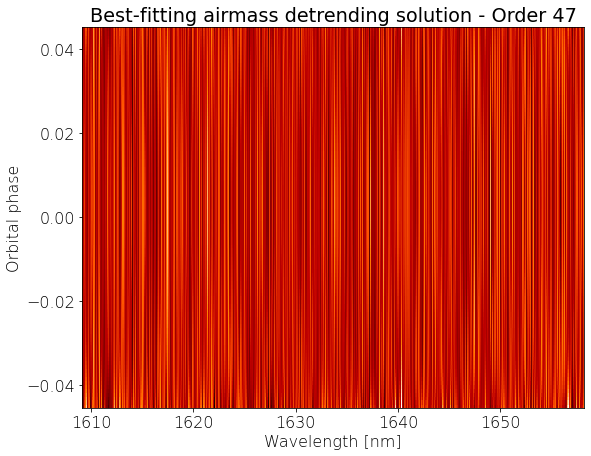

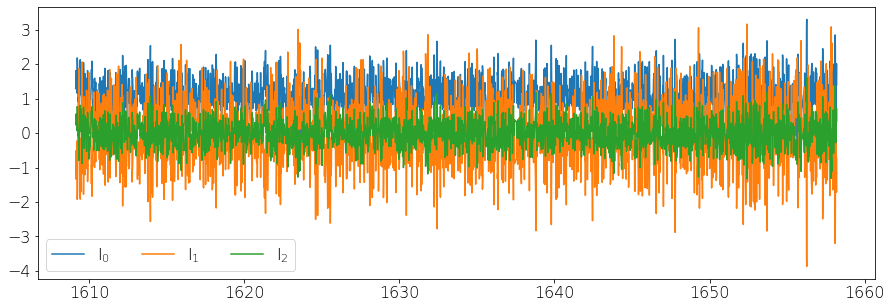

DONE



In [12]:
deg     = 2   ### Degree of the airmass model
numb    = 47  ### Plot best prediction for a given order
oo      = int(np.argmin(np.abs(np.array(orders_fin,dtype=float)-numb)))

print("\nDetrending with airmass")
for kk in range(nord_fin):
    pb, I_pred = list_ord_pl_fin[kk].detrend_airmass(airmass,deg)
    
    if kk == oo:
        O = list_ord_pl_fin[kk]
        plt.figure(figsize=(9,7))
        X,Y = np.meshgrid(O.W_norm,phase)
        plt.pcolor(X,Y,I_pred,cmap="gist_heat")
        plt.xlabel("Wavelength [nm]")
        plt.ylabel("Orbital phase")
        title = "Best-fitting airmass detrending solution - Order " + str(O.number)
        plt.title(title)
        plt.show()
        
        plt.figure(figsize=(15,5))
        for nn,pp in enumerate(pb):
            lab = r"I$_{" + str(nn) + "}$" 
            plt.plot(O.W_norm,pp,label=lab)
        plt.legend(ncol=3)
        plt.show()
    
#         lab   = ["Wavelength","Orbital phase","Flux"]
#         cmap  = "gist_heat"
#         oo    = int(np.argmin(np.abs(np.array(orders,dtype=float)-numb)))
#         title = "Before airmass detrending - order " + str(list_ord[oo].number)
#         size  = (10,7)
#         plot_2D(O.W_norm,phase,O.I_norm,lab,cmap,n_ini,n_end,title,size) 
        
#         lab   = ["Wavelength","Orbital phase","Flux"]
#         cmap  = "gist_heat"
#         oo    = int(np.argmin(np.abs(np.array(orders,dtype=float)-numb)))
#         title = "After airmass detrending - order " + str(list_ord[oo].number)
#         size  = (10,7)
#         plot_2D(O.W_norm,phase,O.I_det,lab,cmap,n_ini,n_end,title,size)       



        
    
    
print("DONE\n")

#########################################################################################

**BONUS 1:** [Brogi et al. 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...615A..16B/abstract) recommend to perform the airmass detrending in the log space (i.e., by working with the logarithm of the flux). Implement a new function *detrend_airmass(I_norm,airmass,deg)* performing the detrending with airmass on the logarithm of the attribute *I_norm* of each Order object of the  list *list_ord_pl_fin*. This function will return a detrended sequence of spectra I_det (in the non-log space) which will be stored in the attribute *I_det* of each Order object of the list *list_ord_pl_fin*. 

#########################################################################################

#### 1.6. Filter bad pixels

In this step, we filter bad pixels (or velocity bins) in each order. We first compute the dispersion of each pixel (along the time axis). In principle, the sequence of spectra should be dominated by white noise by now and, therefore, each observation can be roughly seen as different realization of the photon/instrument noise (we encourage the user to double check this information by e.g., applying a Fourrier transform to the data). As a consequence, we expect the distribution of dispersions along the time axis in each order to shaped like a parabola with: (i) a minimum around the order center (level of dispersion corresponding to the DRS-provided S/N) and (ii) increasing noise at the order extremities (due to the blaze function). We therefore fit a parabola to the distribution of dispersions along the time axis using an iterative outlier removal procedure. All outliers removed in the process are flagged as bad pixels and discarded from the analysis.


Filter bad pixels
Order 75 : 13 pixel removed
Order 74 : 23 pixel removed
Order 73 : 12 pixel removed
Order 72 : 27 pixel removed
Order 71 : 17 pixel removed
Order 70 : 26 pixel removed
Order 69 : 33 pixel removed
Order 68 : 19 pixel removed
Order 67 : 87 pixel removed
Order 66 : 38 pixel removed
Order 65 : 36 pixel removed
Order 64 : 20 pixel removed
Order 63 : 23 pixel removed
Order 62 : 31 pixel removed
Order 61 : 27 pixel removed
Order 60 : 25 pixel removed
Order 59 : 60 pixel removed
Order 58 : 28 pixel removed
Order 57 : 3 pixel removed
Order 53 : 16 pixel removed
Order 52 : 19 pixel removed
Order 51 : 26 pixel removed
Order 50 : 48 pixel removed
Order 49 : 35 pixel removed
Order 48 : 24 pixel removed
Order 47 : 29 pixel removed


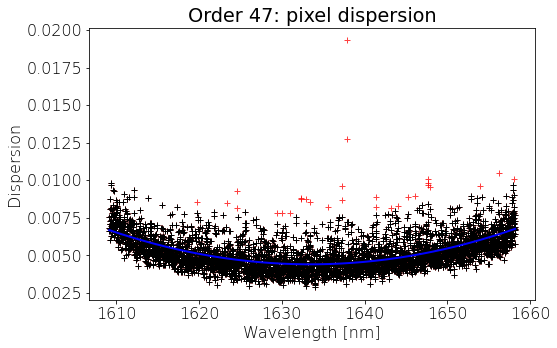

Order 46 : 43 pixel removed
Order 45 : 36 pixel removed
Order 44 : 24 pixel removed
Order 43 : 25 pixel removed
Order 39 : 22 pixel removed
Order 38 : 15 pixel removed
Order 37 : 27 pixel removed
Order 36 : 46 pixel removed
Order 35 : 41 pixel removed
Order 34 : 31 pixel removed
Order 33 : 37 pixel removed
Order 32 : 28 pixel removed
DONE



In [13]:
numb    = 47  ### Index of order displayed 
oo      = int(np.argmin(np.abs(np.array(orders_fin,dtype=float)-numb)))
deg_px  = 2   ### Degree of the polynomial fit
sig_px  = 4.0 ### Threshold for outlier removal [in sigma]
N_px    = 400 ### Size of window (in nb of points) centered on the order center, on which the empirical 
              ### spectrum S/N is computed
print("\nFilter bad pixels")
for kk in range(nord_fin):
    if kk == oo: list_ord_pl_fin[kk].filter_pixel(deg_px,sig_px,True)
    else: list_ord_pl_fin[kk].filter_pixel(deg_px,sig_px,False)
    list_ord_pl_fin[kk].get_pixel_dispersion(N_px)
print("DONE\n")

Here we compare the dispersion empirically-computed from the center of each order to the DRS-provided photon noise:

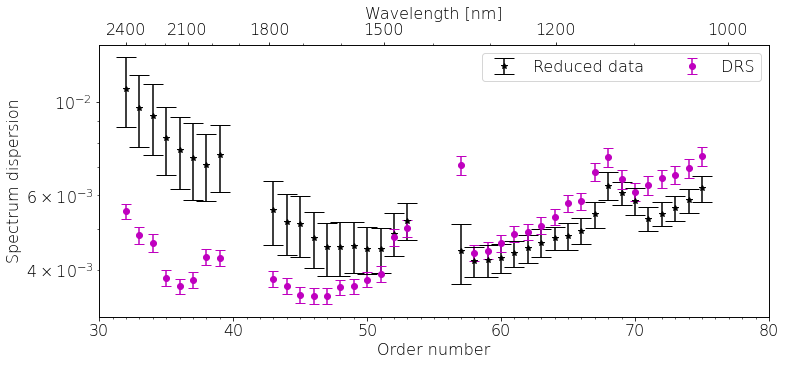

In [14]:
### Display global spectrum dispersion and compare it to DRS
plot_spectrum_dispersion(list_ord_pl_fin)

#### 1.7. Filter correlated noise with Singular Value Decomposition

Although dominated by the white noise, the remaining sequence of spectra is still polluted by correlated noise (e.g., residuals of telluric/stellar spectra). If uncorrected, these components will harm the correlation process, with the result of masking or even mimicking a signature from the planet atmosphere. Hence the interest in using statistical methods, here, principal component analysis (PCA - in fact Singular Value Decomposition here) to remove a substantial fraction of the remaining correlated noise.

More information about PCA can be found one the (pretty well explained) [wikipedia page](https://en.wikipedia.org/wiki/Principal_component_analysis) and its application to a sequence of nIR spectra is described [here](https://ui.adsabs.harvard.edu/abs/2018arXiv180604617B/abstract) and [here](https://ui.adsabs.harvard.edu/abs/2019ApJ...878..153D/abstract). Let's consider our reduced sequence of spectra, $I_{\rm{red}}$, containing N$_{\rm{obs}}$ spectra and N$_{\rm{w}}$ wavelength bins. In the PCA framework, the sequence of spectra (in each order) is described as N$_{\rm{obs}}$ realizations of N$_{\rm{w}}$ random variables (centered and reduced beforehand). A PCA decomposition consists in projected the 2D matrix $I_{\rm{red}}$ onto an orthonormal basis $\mathcal{B}_{\rm{pca}}$ whose vectors are the eigenvectors of the covarance matrix associated to $I_{\rm{red}}$ and given by  $I_{\rm{red}}^{T} I_{\rm{red}}$. One can demonstrate that the larger the eigenvalue, the more the associated eigenvector (called PCA component) contributes to the variance budget of $I_{\rm{red}}$. As a consequence, if $I_{\rm{red}}$ is only drawn by uncorrelated noise, all eigen values will have the same order of magnitude. In contrast, correlated components will induce a discrepency in the distribution of eigenvalues. 

In practice, we use PCA to decompose $I_{\rm{red}}$ into its N$_{\rm{obs}}$ PCA components for each order and sort the eigenvalues (and associated eigenvectors) in decreasing order. We then chose the number of components associated to correlated noise (see next paragraph) and set them to 0, before projecting the PCA decomposition back into the original space. 

**Tuning the number of components to remove:** This step is critical in order to remove most of the residuals of telluric and stellar spectra while preserving the planet atmosphere contribution. Note that the amplitude of the planet atmosphere absorption lines is generally 10-100 times lower than the typical white noise level. From injection tests, we can easily demonstrate that the presence of the planet atmosphere spectrum has only a marginal effect on the distribution of eigenvalues in the PCA decomposition. In this tutorial, we compute the contribution $C$ of each eigenvector to the total variance budget (i.e., $C(e_{i}) = e_{i}/\Sigma_{j}e_{j}$, for all eigenvalue $e_{i}$). All eigenvalue $e_{i}$ for which $c(e_{i})$ is larger than a given user-provided threshold (set to 4% here) is said to be associated to correlated noise and the corresponding component is set to 0. 




As a first step, you can visualize the first components associated to your favorite SPIRou order (select the order index with the parameter **numb** and the number of components displayed with **N_comp**). See the list of order indices and corresponding wavelengths in Section 1.1. You will noticed that the larger the component, the more complex the structures become (similar to taking the derivatives). 

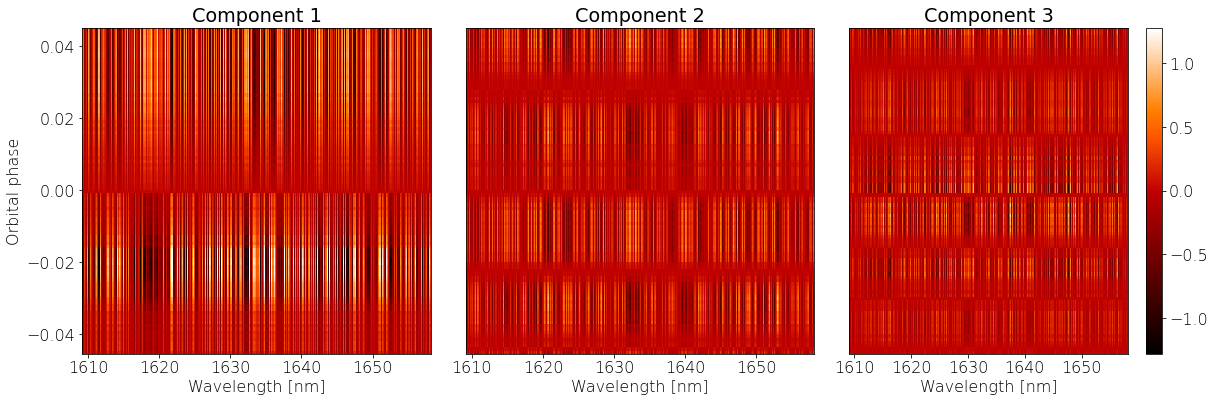

In [15]:
############# Plot the first components
### Note: This cell is just here to visualize PCA components

numb    = 47  ### Select index of order you want to display
oo      = int(np.argmin(np.abs(np.array(orders_fin,dtype=float)-numb)))
O       = list_ord_pl_fin[oo]
N_comp  = 3   ### Show the first N_comp components 
var,I_pca,I_del = make_pca(O.I_red,N_comp,True)
plt.figure(figsize=(20,6))
X,Y = np.meshgrid(O.W_red,phase)
for nn in range(N_comp):
    ax = plt.subplot(1,N_comp,nn+1)
    vi = np.mean(I_del[0]) - 3.*np.std(I_del[0])
    vf = np.mean(I_del[0]) + 3.*np.std(I_del[0])
    cc = plt.pcolor(X,Y,I_del[nn],cmap="gist_heat",vmin=vi,vmax=vf)
    if nn > 0: plt.yticks([])
    if nn == 0: plt.ylabel("Orbital phase")
    if nn == N_comp-1:
        cb   = plt.colorbar(cc,ax=ax)
    title = "Component " + str(nn+1)
    plt.title(title)
    plt.xlabel("Wavelength [nm]")
plt.subplots_adjust(wspace=0.1)
plt.show()

**Main PCA process:** We know use the method described above to tune the number of components removed from the observed sequence of spectra for each order. Warning: this might take a few minutes to run. 

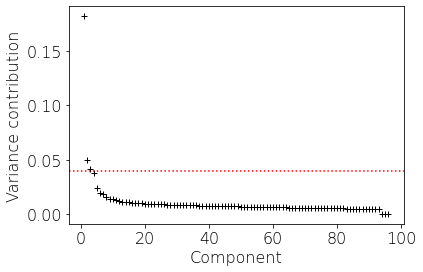

    Order  W_mean [nm]  Components removed
0    75.0  1026.002055                 0.0
1    74.0  1039.760035                 1.0
2    73.0  1053.961925                 1.0
3    72.0  1067.780500                 1.0
4    71.0  1082.786676                 1.0
5    70.0  1098.225868                 1.0
6    69.0  1113.423789                 1.0
7    68.0  1131.171296                 1.0
8    67.0  1147.818047                 1.0
9    66.0  1165.395697                 1.0
10   65.0  1183.370020                 1.0
11   64.0  1202.230490                 1.0
12   63.0  1221.102192                 1.0
13   62.0  1241.200581                 1.0
14   61.0  1261.151448                 1.0
15   60.0  1282.494868                 1.0
16   59.0  1303.441826                 1.0
17   58.0  1325.699398                 1.0
18   57.0  1344.819084                 1.0
19   53.0  1451.909533                 2.0
20   52.0  1479.203240                 2.0
21   51.0  1507.625268                 2.0
22   50.0  

In [16]:
#### Automatic scaling of PCA
numb       = 47   ### Show the distribution of eigenvalues for this order
oo         = int(np.argmin(np.abs(np.array(orders_fin,dtype=float)-numb)))
threshold  = 0.04 ### threshold of variance contribution (above --> PCA components set to 0)
N_comp_fin = np.zeros(nord_fin,dtype=int)
wmean      = np.zeros(nord_fin)

for nn in range(nord_fin):
    
    O_pl             = list_ord_pl_fin[nn]
    evar,I_pca       = make_pca(O_pl.I_red,0)
    indc             = np.where(evar>=threshold)[0]
    wmean[nn]        = O_pl.W_mean
    N_comp_fin[nn]   = len(indc)

    if nn == oo:
        XX = np.arange(len(evar)) + 1
        plt.figure(figsize=(6,4))
        plt.plot(XX,evar,"+k")
        plt.axhline(0.04,ls=":",color="r")
        plt.xlabel("Component")
        plt.ylabel("Variance contribution")
        plt.show()
        
    evar,I_pca   = make_pca(O_pl.I_red,N_comp_fin[nn])
    O_pl.I_pca   = I_pca
    
### Print number of components rejected for each order
infos = np.array([orders_fin,wmean,N_comp_fin]).T
col   = ["Order","W_mean [nm]","Components removed"]
dtf   = pd.DataFrame(infos,columns=col)
print(dtf)



#########################################################################################

**BONUS 2:** Do you have any improvement the tuning the number of PCA components removed from each order? 

#########################################################################################

####  1.8. Summary -- Visualize all the data reduction process for a given order

Display the main steps of the data reduction process for a given order (change **numb** to change the order).

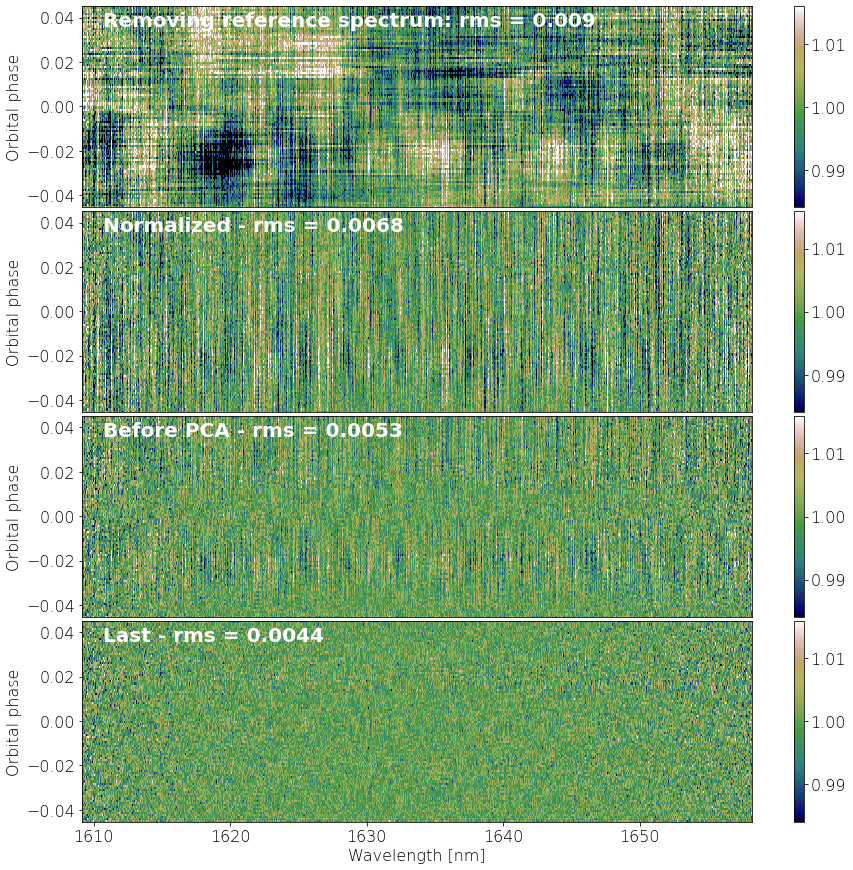

In [17]:
numb = 47  ### Show the evolution of the sequence of spectra for this order
O    = list_ord_pl_fin[int(np.argmin(np.abs(np.array(orders_fin,dtype=float)-numb)))]
cmap = "gist_earth" # Another fancy color map?

plt.figure(figsize=(15,15))

###############################        
ax   = plt.subplot(411)
X,Y  = np.meshgrid(O.W_al,phase)
Z    = O.I_sub
zmin = O.I_red.mean() - 3.*O.I_red.std()
zmax = O.I_red.mean() + 3.*O.I_red.std()
c    = plt.pcolor(X,Y,Z,cmap=cmap,vmin=zmin,vmax=zmax) 
plt.colorbar(c,ax=ax)
ax.set_ylabel("Orbital phase")  
ax.set_xticks([])        
ax.set_xlim(np.min(O.W_red),np.max(O.W_red))

tx = "Removing reference spectrum: rms = " + str(round(np.std(Z),4))                           
plt.text(np.min(O.W_red)+1.5,0.8*np.max(phase),tx,color="w",fontsize=20,fontweight="bold")

###############################  
ax   = plt.subplot(412)
X,Y  = np.meshgrid(O.W_norm,phase)
Z    = O.I_norm
zmin = O.I_red.mean() - 3.*O.I_red.std()
zmax = O.I_red.mean() + 3.*O.I_red.std()
c    = plt.pcolor(X,Y,Z,cmap=cmap,vmin=zmin,vmax=zmax)   
ax.set_ylabel("Orbital phase")  
ax.set_xticks([])        
ax.set_xlim(np.min(O.W_red),np.max(O.W_red))
plt.colorbar(c,ax=ax)

tx = "Normalized - rms = " + str(round(np.std(Z),4))                            
plt.text(np.min(O.W_red)+1.5,0.8*np.max(phase),tx,color="w",fontsize=20,fontweight="bold")


###############################  
ax   = plt.subplot(413)
X,Y  = np.meshgrid(O.W_red,phase)
Z    = O.I_red
zmin = O.I_red.mean() - 3.*O.I_red.std()
zmax = O.I_red.mean() + 3.*O.I_red.std()
c    = plt.pcolor(X,Y,Z,cmap=cmap,vmin=zmin,vmax=zmax)  
ax.set_ylabel("Orbital phase")  
ax.set_xticks([])        
ax.set_xlim(np.min(O.W_red),np.max(O.W_red))
plt.colorbar(c,ax=ax)
tx = "Before PCA - rms = " + str(round(np.std(Z),4))                           
plt.text(np.min(O.W_red)+1.5,0.8*np.max(phase),tx,color="w",fontsize=20,fontweight="bold")


###############################  
ax   = plt.subplot(414)
X,Y  = np.meshgrid(O.W_red,phase)
Z    = O.I_pca
zmin = O.I_red.mean() - 3.*O.I_red.std()
zmax = O.I_red.mean() + 3.*O.I_red.std()
c    = plt.pcolor(X,Y,Z,cmap=cmap,vmin=zmin,vmax=zmax)  
ax.set_ylabel("Orbital phase")  
ax.set_xlim(np.min(O.W_red),np.max(O.W_red))
plt.colorbar(c,ax=ax)
ax.set_xlabel("Wavelength [nm]")

tx = "Last - rms = " + str(round(np.std(Z),4)) 
plt.text(np.min(O.W_red)+1.5,0.8*np.max(phase),tx,color="w",fontsize=20,fontweight="bold")
plt.subplots_adjust(hspace=0.02)
plt.show()

## 2. Planet recovery

In this section, we aim at recovered the planet atmosphere signal injected into the data using a template-matching process (often referred as cross-correlation process in the literature; see [Birkby 2018](https://ui.adsabs.harvard.edu/abs/2018arXiv180604617B/abstract)). The method is relatively simple:
- Your inputs are the observed sequence of spectra (after data and PCA reduction) and a given 1D template of the planet atmosphere spectrum. The user provides a grid of Kp (semi-amplitude of planet RV) and Vsys (RV at mid-transit). 
- For each couple (Kp,Vsys), we compute the expected planet RV, **vp**, given by  (assuming a circular orbit): **vp** = Kp * sin(2$\pi$ $\Phi$) + Vsys; where $\Phi$ is the planet orbital phase centered on the mid-transit time. We then build a sequence of spectra (sampled as the observations) by shifting the planet atmosphere template at each date *t* according to **vp**(*t*) and weighting it by the transit window. We then compute the correlation between the synthetic map and the observed sequence of spectra.
- We repeat the process on all (Kp,Vsys) and obtain a map of correlation (Kp,Vsys). In order to estimate the significance of any peak in the correlation map, we need to estimate the level of correlation associated to pure white noise. This is done, in this tutorial, by computing the typical dispersion in regions of the correlation map where no planetary signal is found (typically, by excluding the regions close to K_inj and V_inv. More robust estimates of the significance can be obtained by 
    1. Computing the correlation map of the template with maps of white noise (possible amplified at the extremities of each order to account for the blaze function). The typical level of error associated to the correlation with the template is given by the dispersion in the correlation with white noise. 
    2. Using a Student-t test which provides a more robust framework to estimate the significance of the signal (see [Brogi et al. 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...817..106B/abstract) or [Birkby 2018](https://ui.adsabs.harvard.edu/abs/2018arXiv180604617B/abstract))
    
**NOTE:** In practice, we want to compare models of planet atmosphere assuming different conditions (e.g., P,T profile, wind dynamics) and compositions. Comparing significance maps does not provide a robust framework to perform a model comparison (and derive accurate error bars for the different parameters of the fit). In practice, the **correlation-to-likelihood** framework introduced in [Zucker 2003](https://ui.adsabs.harvard.edu/abs/2003MNRAS.342.1291Z/abstract) and recently adapted to high-resolution spectral analysis in [Brogi & Line 2019](https://ui.adsabs.harvard.edu/abs/2019AJ....157..114B/abstract) allows to perform the model comparison in the bayesian framework. This allows one to use a Bayesian Markov Chain Monte Carlo (MCMC) to obtain a posterior distribution for the model parameters from which error bars can be estimated. Note that this process takes time (thus beyond the second of this tutorial) and should be parallelise. 

####  What model to you want to use?

We encourage the user to try different models by changing the parameter **name_model** to probe (for a given planet type, hot Jupiter or hot Neptune) the correlation with:
- The exact same template as the one injected as a fiducial case
- Models containing only 1 molecule (H2O, CO, CH4, NH3)

For each model used for the correlation, we plot below the injected planet atmosphere 1D template (black) and the template used for the correlation (magenta). **What molecule can we detect from the data (H2O, NH3, CO, CH4)?**

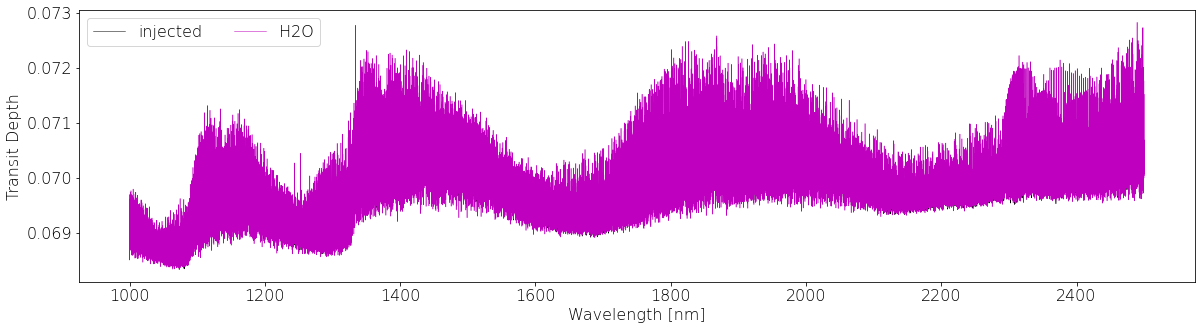

In [18]:
# Indicate below the name of the planet atmosphere template injected in the data
name_model    =  "Model/Jupiter_1sol_Teq1500K_Tint150K"
#name_model    = "Model/Neptune_30sol_Teq600K_Tint50K_CH4"
molec         = "H2O"

aa            = np.loadtxt(name_model)
W_mod         = np.array(1./aa[:,0]*1e7)[::-1]  ### Wavelength of the model [nm]
transit_depth = np.array(aa[:,1])[::-1]         ### Transit depth

plt.figure(figsize=(20,5))
plt.plot(W_mod_inj,transit_depth_inj,"-k",lw=.5,label="injected")
plt.plot(W_mod,transit_depth,"-m",lw=.5,label=molec)
plt.ylabel("Transit Depth")
plt.xlabel("Wavelength [nm]")
plt.legend(ncol=2)
plt.show()

We now select the orders we will use to compute the correlation on. In practice, we advocate to select all available orders exhibiting absorption features to avoid any selection bias in the process (except in the order's spectrum exhibit significant telluric contamination or correlated noise). In our case, we compute the absolute difference between the injected planet template and the model used for the correlation. If this difference is larger than 2%, we discard the order. 



Orders ok for correlation with model H2O :
0 1014.8663833224683 1036.6298737315258
1 1028.28454831894 1050.661399562598
2 1042.1372948193098 1065.1989859189875
3 1056.3730540179045 1078.7161743938045
4 1071.070471156716 1094.0875790726202
5 1086.2134069796675 1109.6465437298928
6 1101.6475717886342 1124.2607044217855
7 1118.1744900683168 1143.1855739847956
8 1133.8355645449194 1160.34431788106
9 1151.5420310844588 1178.1259111122504
10 1168.1045905487736 1197.6907986354174
11 1187.0380234994302 1216.6238132653746
12 1204.8565021469578 1236.3608879176718
13 1225.0236468935743 1256.533028351213
14 1243.9927191458044 1277.221647473631
15 1265.8124637028 1298.590849811825
16 1285.3216897375705 1320.3329405672616
17 1307.5946982658702 1343.1899895677095
18 1332.9519859212792 1343.6782406472917
19 1440.2222090532862 1468.5303525025688
20 1457.885824753162 1498.6237528926895
21 1485.4057361877801 1527.9765634588928
22 1514.2812209059468 1558.5638209901294
23 1543.3871876731293 1590.46278530

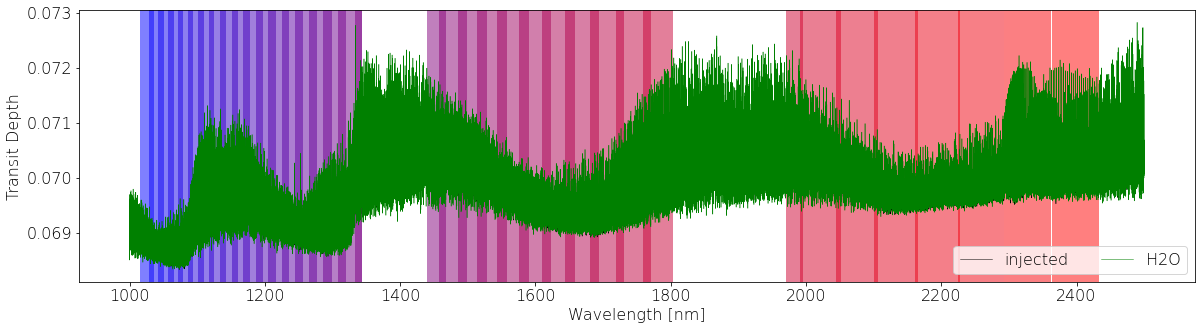

In [19]:
### Set the model to each relevant order
discard           = np.zeros(nord_fin)
list_ord_corr     = []
orders_corr       = []
index_orders_corr = []
Wmin_corr         = []
Wmax_corr         = []

for kk,O in enumerate(list_ord_pl_fin):
    #print(kk,O.W_red.min())
    Wmin,Wmax = 0.95*O.W_red.min(),1.05*O.W_red.max()
    indm      = np.where((W_mod>Wmin)&(W_mod<Wmax))[0]
    W_sel     = W_mod[indm]
    S         = np.std(transit_depth[indm])
    diff_transit=np.abs(np.mean(transit_depth[indm])-np.mean(transit_depth_inj[indm]))/np.mean(transit_depth_inj[indm])    
    #if np.min(W_sel) > 0.99*O.W_red.min() or np.max(W_sel) < 1.01*O.W_red.max() or S<1e-4:
    #if np.min(W_sel) > 0.99*O.W_red.min() or np.max(W_sel) < 1.01*O.W_red.max() or diff_transit>0.02: 
    if diff_transit>0.02:         
        print("Order",O.number," - Wm = ",wmean[kk],"nm - incomplete -- discarded (dispersion:",round(S,8),")") 
    else:
        ### If order selected, we save wavelength and 1-transit_depth in Order object's attributes
        O.Wm = W_sel
        O.Im = 1. - transit_depth[indm]
        list_ord_corr.append(O)
        orders_corr.append(O.number)
        index_orders_corr.append(kk)
        Wmin_corr.append(O.W_red.min())
        Wmax_corr.append(O.W_red.max())        
print("\n\nOrders ok for correlation with model",molec,":")


### Plot model and associated orders
plt.figure(figsize=(20,5))
plt.plot(W_mod_inj,transit_depth_inj,"-k",lw=.5,label="injected")
plt.plot(W_mod,transit_depth,"-g",lw=.5,label=molec)
plt.ylabel("Transit Depth")
plt.xlabel("Wavelength [nm]")
plt.legend(ncol=2)
amount=len(orders_corr)-1
for kk,i in enumerate(orders_corr): 
    print(kk, Wmin_corr[kk], Wmax_corr[kk])
    c = [float(kk)/float(amount), 0.0, float(amount-kk)/float(amount)]
    plt.axvspan(Wmin_corr[kk], Wmax_corr[kk],color=c, alpha=0.5, lw=0) 



#########################################################################################

**BONUS 3:** Select the orders used in the correlation process using a merit/weight order-dependent function? 

#########################################################################################

#### Main parameters of the grid for the correlation process

Select here the min/max values and the number of points for the (Kp,Vsys) grid. In this tutorial, we advocate to include no more than 20/30 steps for the Kp grid (for time purposes). 

In [20]:
### Parameters of the grid

### Semi-amplitude of the planet RV [km/s]
Kpmin = 50.0 #Jupiter
Kpmax = 250.0#Jupiter
#Kpmin = -50.0 #Neptune
#Kpmax = 150.0 #Neptune

Nkp   = 20 ### Size of the grid
Kp    = np.linspace(Kpmin,Kpmax,Nkp)

### Mid-transit planet RV [km/s]
Vmin = -30.0
Vmax =  30.0
Nv   = 61
Vsys = np.linspace(Vmin,Vmax,Nv)

### Order selection for computing the correlation (either manually or automatically)
#ord_sel = [50, 49, 48, 47, 46, 36, 35, 34]  #[70,58,47,46,32]  ### Manual seletion
ord_sel=orders_corr ### Automatic selection

#### Compute correlation maps

**Takes some time**

For each selected SPIRou order and for each sample of the (Kp,Vsys) grid:
- Interpolate the planet atmosphere spectrum.
- Build a sequence of planet atmosphere spectra by (1) shifting the planet atmosphere template according to the planet RV solution and weighting it by the transit window at each observation time, (2) bin each spectrum at the resolution of the SPIRou observations.
- Compute the average correlation coefficient between the observed and synthetic spectra

In [21]:
ind_sel = []
for kk,oo in enumerate(list_ord_corr):
    if oo.number in ord_sel: ind_sel.append(kk)
corr_pl = compute_correlation(np.array(list_ord_corr)[ind_sel],window,phase,Kp,Vsys)


Initialization
Interpolate model
Compute correlation for 38 orders
DONE!
Duration: 6.293310538927714 min


#### Post-analysis

- Compute maximum significance
- Compute error bars on Kp ad Vsys

We first convert the correlation map into a significance map by dividing it by the typical dispersion of the noise in the correlation map. The latter is simply computed by taking the standard deviation of the correlation map, on regions where the planetary signal is expected to be (mostly) absent (note that this is a simplistic approach and that, in practice, additional statistical tests can ensure a more robust estimation of the noise level, see [Birkby 2018](https://ui.adsabs.harvard.edu/abs/2018arXiv180604617B/abstract).). **Note:** Another method to estimate the typical noise level in the correlation map would be to compute the correlation map between the planet atmosphere template and a 2D matrix containing only noise (possibly amplified at the extremity of each order to account for the blaze function). The typical noise level is then simply given by the dispersion of the obtained correlation map.

We then fit a bivariate normal law to the significance map in the (Kp,Vsys) space and derive the best-fitting Kp and Vsys as well as the maximum significance. To compute the error bars on Kp and Vsys, we compute a densely-sampled bivariate normal law using the best-fitting parameters previously obtained. Then, starting from the maximum significance, we search the distance in the Kp space (resp. V_sys space) such that the significance decreases by 1 sigma (freezing the other parameter to its best estimate). Note that, if the grid is too small (and than no level lower than 1 sigma from the max is identified), we return the size of the grid as an error bar on the parameter as well as a warning message. In practice, we advocate to run the correlation maps on finely-sampled large grids in the (Kp,Vsys) space in order to ensure that the maximum of correlation is indeed global.

In [22]:
#### Compute statistics and plot the map

# Indicate regions to exclude when computing the NOISE level from the correlation map
Kp_lim    = [110,190]   # Exclude this Kp range we
Vsys_lim  = [-15.,15.]


### Compute significance map
snrmap_fin  = get_snrmap(np.array(orders_corr)[ind_sel],Kp,Vsys,corr_pl,Kp_lim,Vsys_lim)
sig_pl_fin  = np.sum(corr_pl[:,:,:]/snrmap_fin,axis=2)

### Get and display statistics
p_best,K_best,K_sup,K_inf,V_best,V_sup,V_inf = get_statistics(Vsys,Kp,sig_pl_fin)

Fit bivariate normal law on significance map
Maximum detection: 3.8 sigma
Best estimates:
Kp: 170.7 (+ 51.3 ,- 50.7 ) km/s
V0: -0.3 (+ 2.1 ,- 2.1 ) km/s


Plot the correlation maps:
- Color map showing the significance of the correlation with the planet template in the (Kp,Vsys) space
- 1D cuts at the injected values of Kp and Vsys
In each case, we indicate the injected values of Kp and Vsys by white dashed lines

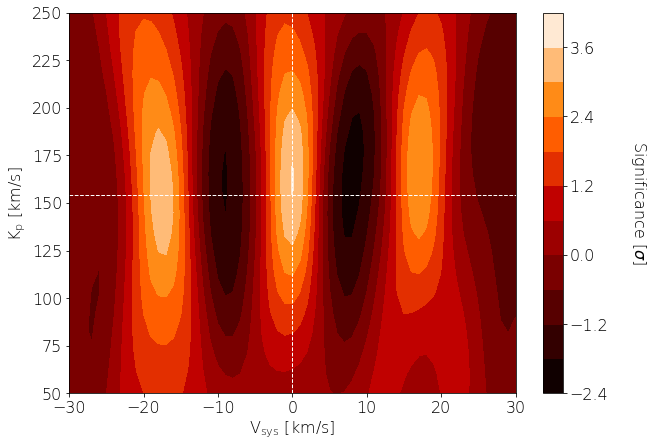

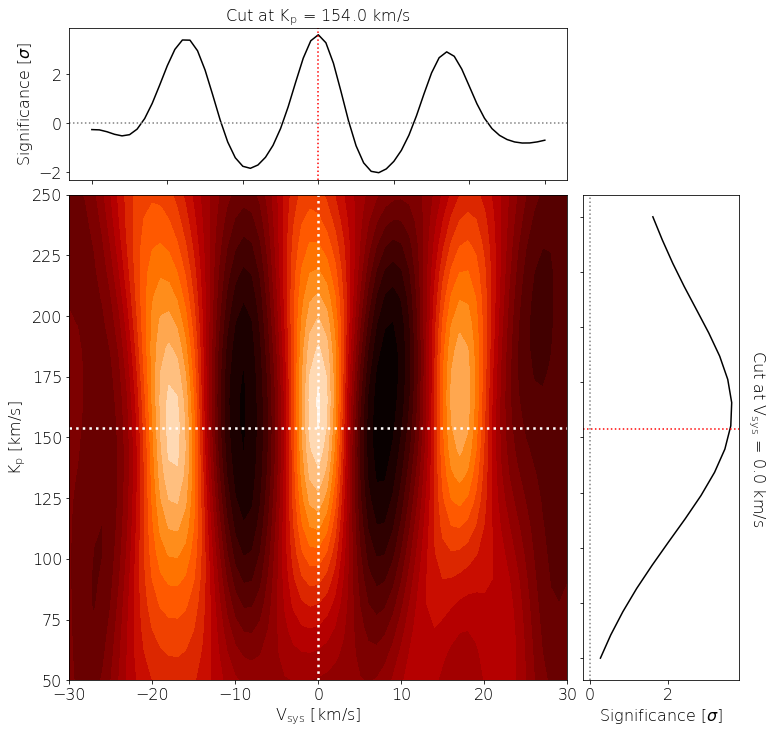

In [23]:
K_cut   = K_inj
V_cut   = V_inj
ind_v   = np.argmin(np.abs(Vsys-V_cut))
ind_k   = np.argmin(np.abs(Kp-K_cut))
sn_map  = sig_pl_fin
sn_cutx = sn_map[:,ind_v]
sn_cuty = sn_map[ind_k]

cmap = "gist_heat"
plot_correlation_map(Vsys,Kp,sn_map,V_inj,K_inj,cmap)

### Plot correlation + 1D cut
plot_correlation_map(Vsys,Kp,sn_map,V_inj,K_inj,cmap,sn_cutx,sn_cuty,20)

#########################################################################################

**BONUS 4:** Using the planet atmosphere template *Jupiter_1sol_Teq1500K_Tint150K_superrot.txt*, try to probe the signature of super rotation in the planet atmosphere?

#########################################################################################

#########################################################################################

**BONUS 5:** By implementing a cross-correlation process between the planet atmosphere template and each observed spectrum, try to probe the mean planet signature in the (time,V_sys) space?

#################################################################################